In [37]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import warnings


from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.datasets import mnist
from keras.utils import to_categorical

In [38]:


# This class is for a fully-connected feedforward neural network using stochastic gradient descent
#
# Inputs:
#
#   layers - a list of numbers of neurons in each layer
#
#   alpha - learning rate
#
#   lambda1 - L1 penalty coefficient
#
#   lambda2 - L2 penalty coefficient
#
#   batchSize - size of mini-batches for SGD
#
#   loss - string to choose which loss function to use:
#     'sum-of-squares'
#     'cross-entropy'

class FeedforwardNeuralNetwork:
    
    def __init__(self, layers, alpha = 0.1, lambda1 = 0, lambda2 = 0, batchSize = 32, loss = 'sum-of-squares', activation = 1):
        # list of weight matrices between layers
        self.W = []
        
        # network architecture will be a vector of numbers of nodes for each layer
        self.layers = layers
        
        # learning rate
        self.alpha = alpha
        
        # L1 penalty coefficient
        self.lambda1 = lambda1
        
        # L2 penalty coefficient
        self.lambda2 = lambda2
        
        # batch size
        self.batchSize = batchSize
        
        # loss function
        self.loss = loss
        
        # initialize the weights (randomly) -- this is our initial guess for gradient descent
        
        # initialize the weights between layers (up to the next-to-last one) as normal random variables
        for i in np.arange(0, len(layers) - 2):
            if activation == 3:
                self.W.append(np.abs(np.random.randn(layers[i] + 1, layers[i + 1] + 1)/100.0))
            else:
                self.W.append(np.random.randn(layers[i] + 1, layers[i + 1] + 1)/100.0)
            
        # initialize weights between the last two layers (we don't want bias for the last one)
        if activation == 3: #this segment will make the random values postive for relu
                self.W.append(np.abs(np.random.randn(layers[-2] + 1, layers[-1])/100.0))
        else:
            self.W.append(np.random.randn(layers[-2] + 1, layers[-1])/100.0)
        
        
    # define the activation function
    def sigmoid(self, x):
        return 1.0 / (1 + np.exp(-x))
    
    # define the activation derivative (where x is the INPUT to activation function)
    def sigmoidDerivative(self, z):
        return z * (1 - z)



    # define the sigmoid derivative (where z is the output of a sigmoid)
    def sigmoidDerivative(self, z):
        return z * (1 - z)



    #define the tanh activation
    def tanh(self,x):
        return np.tanh(x)
        
        
        
    #define ther derivative of tanh
    def tanhDerivative(self, x):
        inside = x
        x = np.e**(inside)
        y = np.e**(-1*inside)
        
        term2 = x + y

        
        #return (2 / term2)**2
        return 1 - (self.tanh(x))**2
        #return self.sigmoidDerivative(2*x)

    def reLU (self, x): #def relu
        return np.maximum(0.0,x)
    def reLUDerivative (self, x): #def relu derivative
        x[x<=0] = 0.0
        x[x>0] = 1.0
        return x
    
    def getNextBatch(self, X, y, batchSize):
        for i in np.arange(0, X.shape[0], batchSize):
            yield (X[i:i + batchSize], y[i:i + batchSize])
    
    # fit the model
    def fit(self, X, y, testX, testY, epochs = 10000, update = 1000, printPerformance = True, activation = 1):
        self.active = activation
        # add a column of ones to the end of X
        X = np.hstack((X, np.ones([X.shape[0],1])))
        losses = []
        trainAccuracies = []
        testAccuracies = []
        trainY = y
        
        numberOfExamples = X.shape[0]
        
        # use one-hot encoding for the training labels
        y = to_categorical(y)

        for epoch in np.arange(0,epochs):
            
            # randomize the examples
            p = np.arange(0,X.shape[0])
            np.random.shuffle(p)
            X = X[p]
            y = y[p]

            # feed forward, backprop, and weight update
            for (x, target) in self.getNextBatch(X, y, self.batchSize):
                # make a list of output activations from the first layer
                # (just the original x values)
                A = [np.atleast_2d(x)]
                
                # feed forward
                for layer in np.arange(0, len(self.W)):
                    
                    # feed through one layer and apply sigmoid activation
                    net = A[layer].dot(self.W[layer])
                    
                    if(activation == 1):  #this is used to switch between activation functions
                     out = self.sigmoid(net)
                    elif(activation == 2):
                     out = self.tanh(net)
                                         
                    else:
                     out = self.reLU(net)
                    
                    # add our network output to the list of activations
                    A.append(out)
                    
                # backpropagation (coming soon!)
                error = A[-1] - target
                
                if self.loss == 'sum-of-squares':
                    
                    if(activation == 1):
                     D = [error * self.sigmoidDerivative(A[-1])]
                    elif(activation == 2):
                     D = [error * self.tanhDerivative(A[-1])]
                    else:
                     D = [error * self.reLUDerivative(A[-1])]
                    
                if self.loss == 'cross-entropy':
                    D = [error]
                
                # loop backwards over the layers to build up deltas
                for layer in np.arange(len(A) - 2, 0, -1):
                    delta = D[-1].dot(self.W[layer].T)
                    
                    if(activation == 1): #this is used to switch between activation functions
                     delta = delta * self.sigmoidDerivative(A[layer])
                    elif(activation == 2):
                     delta = delta * self.tanhDerivative(A[layer])
                    else:
                     delta = delta * self.reLUDerivative(A[layer])
                    D.append(delta)
                    
                # reverse the deltas since we looped in reverse
                D = D[::-1]
                
                # weight update
                for layer in np.arange(0, len(self.W)):
                    self.W[layer] -= self.alpha * (A[layer].T.dot(D[layer])
                                                   + 2 * (self.lambda2 / numberOfExamples) * self.W[layer]
                                                   + (self.lambda1 / numberOfExamples) * np.sign(self.W[layer]) * self.W[layer])

            # print the loss (or maybe more) each 'update' number of epochs
            if (epoch + 1) % update == 0:
                
                # compute the loss
                loss = self.computeLoss(X,y, activation)

                # if we choose, compute the accuracy (this makes it run slower)
                if printPerformance:
                    predictedY = self.predict(testX)
                    predictedY = predictedY.argmax(axis=1)
                    testAccuracy = accuracy_score(testY, predictedY)           

                    predictedY = self.predict(trainX)
                    predictedY = predictedY.argmax(axis=1)
                    trainAccuracy = accuracy_score(trainY, predictedY)

                    testAccuracies.append(testAccuracy)
                    trainAccuracies.append(trainAccuracy)
                    losses.append(loss)
                    
                    # print('Epoch =', epoch + 1, '\tloss =', loss)
                    
                # otherwise, simply print the training loss
                else:
                    losses.append(loss)
                    print('Epoch =', epoch + 1, '\tloss =', loss)

        # if we chose to print the performance, plot loss, training accuracy, and test accuracy for each epoch
        if printPerformance:
            
            

            # plot the losses
            #this segment will split the plat dr white made into two different plots
            fig, ax1 = plt.subplots()
            p1 = ax1.plot(np.arange(0, epochs, update), losses, label = 'Loss')
            ax1.set_xlabel('Training epochs')
            ax1.set_ylabel('Loss')
            ax1.set_xlim(0,100)
            ax1.set_ylim(0,35000)

            fig, ax2 = plt.subplots()
            p2 =  ax2.plot(np.arange(0, epochs, update), trainAccuracies, label = 'Accuracy (train)', color = 'tab:orange')
            p3 = ax2.plot(np.arange(0, epochs, update), testAccuracies, label = 'Accuracy (test)', color = 'tab:green')
            ax2.set_xlabel('Training Epochs')
            ax2.set_ylabel('accuracy')
            ax2.set_ylim(0,1)
            # if activation == 3:
            #     temp = np.arange(0, epochs, update)
               
            #     p1 = ax1.plot(temp, losses, label = 'Loss')
            # else:
            #      p1 = ax1.plot(np.arange(0, epochs, update), losses, label = 'Loss')
            # ax1.set_xlabel('Training Epoch')
            # ax1.set_ylabel('Loss')

            # # make another y axis using the same x axis
            # ax2 = ax1.twinx()
            # ax2.set_ylim([0.5, 1])
            
            # # plot the accuracy
            # p2 = ax2.plot(np.arange(0, epochs, update), trainAccuracies, label = 'Accuracy (train)', color = 'tab:orange')
            # p3 = ax2.plot(np.arange(0, epochs, update), testAccuracies, label = 'Accuracy (test)', color = 'tab:green')
            # ax2.set_ylabel('Accuracy')
            
            # add a legend 
            ps = p2 + p3
            pw = p1
            labs = [p.get_label() for p in ps]
            labs2 = [p.get_label() for p in pw]
            ax1.legend(p1, labs2, loc=0)
            ax1.legend(ps, labs, loc=0)
            
    # feed data into the network and compute the outputs
    def predict(self, X, addOnes = True, activation = 1):
        
        # initialize data, be sure it's the right dimension
        p = np.atleast_2d(X)
        
        # add a column of 1s for bias
        if addOnes:
            p = np.hstack((p, np.ones([X.shape[0],1])))
        
        # feed forward!
        for layer in np.arange(0, len(self.W)):
            
            if(activation == 1): #this is used to switch between activation functions
                p = self.sigmoid(np.dot(p, self.W[layer]))
            elif(activation == 2):
                p = self.tanh(np.dot(p, self.W[layer]))
            else:
                p = self.reLU(np.dot(p, self.W[layer]))
            
        # return the predictions
        return p
    
    # compute the loss function
    def computeLoss(self, X, y, act):
        
        # initialize data to the right dimension
        y = np.atleast_2d(y)
        
        # feed the datapoints through the network to get predicted outputs
        predictions = self.predict(X, addOnes = False, activation=act)
        
        # if the loss function is sum of squares, compute it
        if self.loss == 'sum-of-squares':
            loss = np.sum((predictions - y)**2) / 2.0
            
        # if the loss function is cross-entropy, compute it
        if self.loss == 'cross-entropy':
            loss = np.sum(np.nan_to_num(-y*np.log(predictions)-(1-y)*np.log(1-predictions)))
        
        # add L1 and L2 penalty
        L1penalty = 0
        L2penalty = 0
        
        # add up L1 and L2 penalties from each layer
        for layer in np.arange(0,len(self.W)):
            L1penalty += np.sum(np.abs(self.W[layer]))
            L2penalty += np.sum(self.W[layer] ** 2)
        
        # L1 and L2 penalties to the loss
        loss += (self.lambda1 / X.shape[0]) * L1penalty
        loss += (self.lambda2 / X.shape[0]) * L2penalty
        
        return loss




TanH Activation function


The code segment below is running the tanh activiavtion function. it has also been tuned to give a better output, even though it still is bad it is a lot better than it used to be. Tanh is also the slowest method to run

Test set accuracy
              precision    recall  f1-score   support

           0       0.55      0.94      0.69       980
           1       0.50      0.99      0.66      1135
           2       0.72      0.24      0.36      1032
           3       0.61      0.68      0.64      1010
           4       0.63      0.50      0.56       982
           5       1.00      0.01      0.01       892
           6       0.55      0.90      0.68       958
           7       0.52      0.82      0.64      1028
           8       0.84      0.04      0.07       974
           9       0.46      0.26      0.33      1009

    accuracy                           0.55     10000
   macro avg       0.64      0.54      0.47     10000
weighted avg       0.63      0.55      0.47     10000



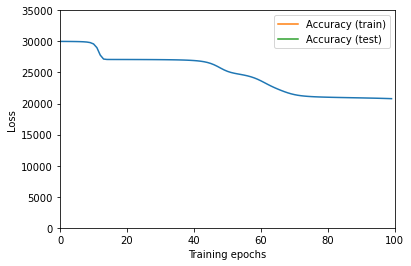

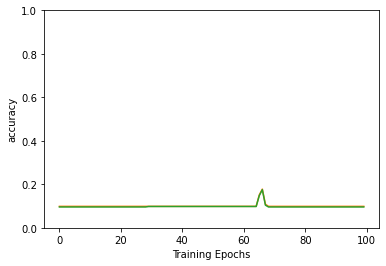

In [46]:
# load the full MNIST dataset: both data and labels
((trainX, trainY), (testX, testY)) = mnist.load_data()

# scale the data to values in [0,1]
trainX = trainX.astype('float32')/255.0
testX = testX.astype('float32')/255.0

# reshape the data
trainX = trainX.reshape([60000, 28*28])
testX = testX.reshape([10000, 28*28])

# fit the model to the training data
model = FeedforwardNeuralNetwork([784, 16, 16, 10], 0.0001, 0.9, 0.9, 32, 'sum-of-squares')





model.fit(trainX,trainY,testX,testY,100,1, activation=2)

print("Test set accuracy")
testY = to_categorical(testY)
predictedY = model.predict(testX,True,2)
predictedY = predictedY.argmax(axis=1)

testY = testY.argmax(axis=1)
print(classification_report(testY, predictedY))

reLU activation function

the reLU activation function is the faster of all the functions and the second most accurate. sigmoid is still the best though

Test set accuracy
              precision    recall  f1-score   support

           0       0.82      0.99      0.89       980
           1       0.97      0.98      0.97      1135
           2       0.87      0.93      0.90      1032
           3       0.95      0.85      0.90      1010
           4       0.81      0.97      0.88       982
           5       0.88      0.85      0.87       892
           6       0.92      0.94      0.93       958
           7       0.98      0.90      0.94      1028
           8       0.93      0.86      0.89       974
           9       0.95      0.75      0.84      1009

    accuracy                           0.90     10000
   macro avg       0.91      0.90      0.90     10000
weighted avg       0.91      0.90      0.90     10000



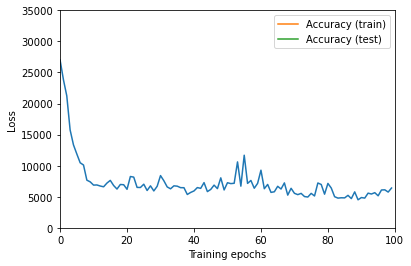

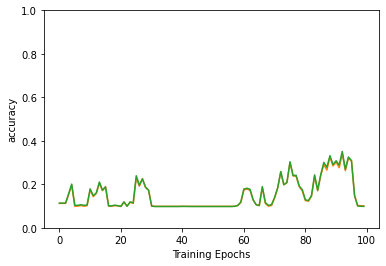

In [40]:
# load the full MNIST dataset: both data and labels
((trainX, trainY), (testX, testY)) = mnist.load_data()

# scale the data to values in [0,1]
trainX = trainX.astype('float32')/255.0
testX = testX.astype('float32')/255.0

# reshape the data
trainX = trainX.reshape([60000, 28*28])
testX = testX.reshape([10000, 28*28])

# fit the model to the training data
model = FeedforwardNeuralNetwork([784, 16, 16, 10], 0.001, 0.5, 0.2, 32, 'sum-of-squares', activation = 3)
model.fit(trainX, trainY, testX, testY, 100, 1, activation = 3)






print("Test set accuracy")
testY = to_categorical(testY)
predictedY = model.predict(testX, activation = 3)
predictedY = predictedY.argmax(axis=1)

testY = testY.argmax(axis=1)
print(classification_report(testY, predictedY))

Sigmoid

this is the defualt sigmoid fucntion.

The sigmoid function is not the slowest to run and it also has the highest accuracy, ergo the sigmoid is the function That I will be using in the later part of the homework


Moving on to problem 5. I think that added more layers will yeild diminishing results and might even make things worse. The reason for this is that as the model gets more complex the more room for error there is, there is a very speific goldy locks zone that needs to be found. It is for this reason that I can not say that small models are better. larger models might learn the training data to well and become overfittefd and thus lose to small models that are not as sensitive to the intial conditions.

Test set accuracy
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       980
           1       0.99      0.98      0.98      1135
           2       0.95      0.94      0.94      1032
           3       0.88      0.94      0.91      1010
           4       0.95      0.93      0.94       982
           5       0.93      0.90      0.92       892
           6       0.95      0.96      0.96       958
           7       0.96      0.94      0.95      1028
           8       0.94      0.89      0.91       974
           9       0.90      0.93      0.92      1009

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



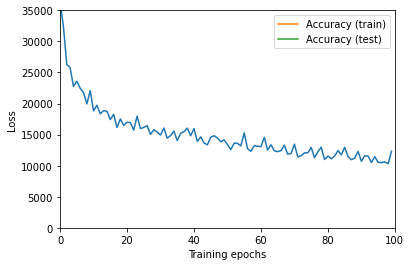

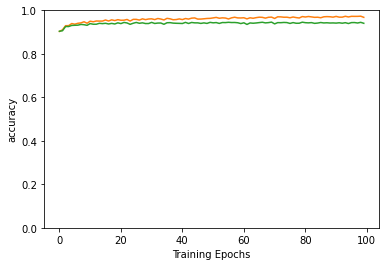

In [41]:
# load the full MNIST dataset: both data and labels #end of other parts and start of 5
((trainX, trainY), (testX, testY)) = mnist.load_data()

# scale the data to values in [0,1]
trainX = trainX.astype('float32')/255.0
testX = testX.astype('float32')/255.0

# reshape the data
trainX = trainX.reshape([60000, 28*28])
testX = testX.reshape([10000, 28*28])

# fit the model to the training data
model = FeedforwardNeuralNetwork([784, 16, 16, 10], 0.05, 0.0, 0.0, 32, 'cross-entropy')
model.fit(trainX, trainY, testX, testY, 100, 1)






print("Test set accuracy")
testY = to_categorical(testY)
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)

testY = testY.argmax(axis=1)
print(classification_report(testY, predictedY))

/tmp/ipykernel_6780/644334061.py:61: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1 + np.exp(-x))
/tmp/ipykernel_6780/644334061.py:61: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1 + np.exp(-x))
/tmp/ipykernel_6780/644334061.py:61: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1 + np.exp(-x))
/tmp/ipykernel_6780/644334061.py:61: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1 + np.exp(-x))
/tmp/ipykernel_6780/644334061.py:61: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1 + np.exp(-x))
/tmp/ipykernel_6780/644334061.py:61: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1 + np.exp(-x))
/tmp/ipykernel_6780/644334061.py:61: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1 + np.exp(-x))
/tmp/ipykernel_6780/644334061.py:61: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1 + np.exp(-x))
/tmp/ipykernel_6780/644334061.py:61: RuntimeWarning: overflow encountered in exp
  return 1.0 / 

Test set accuracy
              precision    recall  f1-score   support

           0       0.96      0.89      0.92       980
           1       0.92      0.85      0.88      1135
           2       0.88      0.71      0.79      1032
           3       0.83      0.62      0.71      1010
           4       0.80      0.90      0.85       982
           5       0.59      0.84      0.69       892
           6       0.79      0.81      0.80       958
           7       0.97      0.85      0.91      1028
           8       0.65      0.75      0.70       974
           9       0.81      0.86      0.84      1009

    accuracy                           0.81     10000
   macro avg       0.82      0.81      0.81     10000
weighted avg       0.82      0.81      0.81     10000



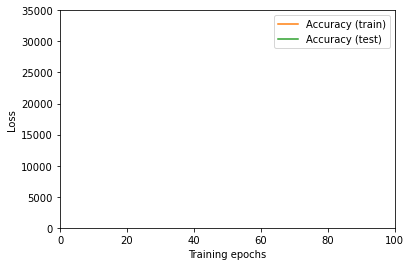

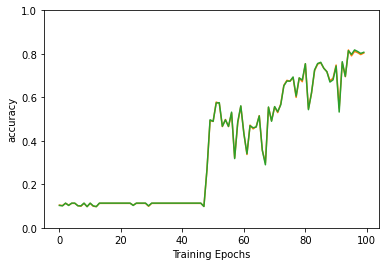

In [42]:
# load the full MNIST dataset: both data and labels
((trainX, trainY), (testX, testY)) = mnist.load_data()

# scale the data to values in [0,1]
trainX = trainX.astype('float32')/255.0
testX = testX.astype('float32')/255.0

# reshape the data
trainX = trainX.reshape([60000, 28*28])
testX = testX.reshape([10000, 28*28])

# fit the model to the training data
model = FeedforwardNeuralNetwork([784, 16, 16, 16, 16, 16, 16, 10], 0.05, 0.0, 0.0, 32, 'cross-entropy')
model.fit(trainX, trainY, testX, testY, 100, 1)






print("Test set accuracy")
testY = to_categorical(testY)
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)

testY = testY.argmax(axis=1)
print(classification_report(testY, predictedY))

Test set accuracy
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       980
           1       0.98      0.98      0.98      1135
           2       0.94      0.93      0.93      1032
           3       0.93      0.92      0.93      1010
           4       0.94      0.95      0.94       982
           5       0.91      0.92      0.92       892
           6       0.94      0.96      0.95       958
           7       0.94      0.94      0.94      1028
           8       0.93      0.93      0.93       974
           9       0.95      0.91      0.93      1009

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



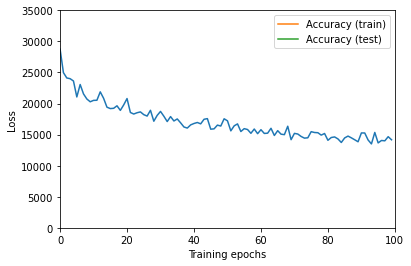

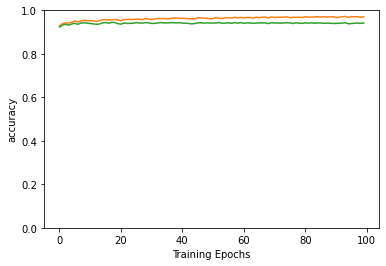

In [43]:
# load the full MNIST dataset: both data and labels
((trainX, trainY), (testX, testY)) = mnist.load_data()

# scale the data to values in [0,1]
trainX = trainX.astype('float32')/255.0
testX = testX.astype('float32')/255.0

# reshape the data
trainX = trainX.reshape([60000, 28*28])
testX = testX.reshape([10000, 28*28])

# fit the model to the training data
model = FeedforwardNeuralNetwork([784, 16, 10], 0.05, 0.0, 0.0, 32, 'cross-entropy')
model.fit(trainX, trainY, testX, testY, 100, 1)






print("Test set accuracy")
testY = to_categorical(testY)
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)

testY = testY.argmax(axis=1)
print(classification_report(testY, predictedY))

As I predicted adding to many layers brought the accuracy down. but we also saw that the difference between 2 hidden layers and 1 hidden layer is not that big at all. From this we can conclude that goldy locks zone that we are looking for is somewhat broad, so the need to balance preformance with meaningful output is definatly a concern. Over all I think for this problem 2 layers are the ideal point.